In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

device = "cuda:5"
model_id = "gpt2-large"
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import torch

nltk.download('punkt')
nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('english'))

# Assuming 'matches', 'dialog', 'offset', and 'perpl' are defined earlier in your code
def perplexity_to_info(dialog, tokens, perpl, answers, pattern = '<(SPK[1-9]|MOD)>'):

    matches = re.findall(pattern, "".join(dialog))
    unique_matches = np.unique(matches)
    #encodings = tokenizer(" ".join(dialog), return_tensors="pt")
    encodings = torch.cat(tokens)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    ppl_to_info = []
    prev_idx_pp = 0
    for idx, (match,answer) in enumerate(zip(matches,answers)):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        label = re.sub(r'\[([^\]]+)\]: ', '', dialog[idx])
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        perpl_per_sent = perpl[prev_idx_pp:idx_pp]
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        prev_idx_pp=idx_pp
        ppl_to_info.append({"label":answer, "perpl": np.asarray(perpl_per_sent)})
    
    return ppl_to_info

def filter_out_common_words(words, perpl):
    # Remove stop words and corresponding perplexity values
    filtered_words = [word for word in words if word.lower().strip() not in STOP_WORDS]
    filtered_word_indices = [i for i, word in enumerate(words) if word.lower().strip() not in STOP_WORDS]
    assert len(list(np.asarray(perpl)[filtered_word_indices])) == len(filtered_words)
    return list(np.asarray(perpl)[filtered_word_indices]), filtered_word_indices

def perplexity_to_info_filtering_out_common_words(dialog, tokens, perpl, answers, matches, pattern = '<(SPK[1-9]|MOD)>'):
    
    encodings = torch.cat(tokens)
    unique_matches = np.unique(matches)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    
    ppl_to_info = []
    prev_idx_pp = 0
    dialog_filtered = []
    for idx, (match,answer) in enumerate(zip(matches,answers)):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        label = re.sub(pattern, '', dialog[idx])
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        assert len(decoded) == len(perpl[prev_idx_pp:idx_pp])
        perpl_per_sent, filtered_word_indices = filter_out_common_words(decoded, perpl[prev_idx_pp:idx_pp])
        assert len(perpl_per_sent) == len(tokens[filtered_word_indices])
        dialog_filtered.append(tokens[filtered_word_indices])
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        prev_idx_pp=idx_pp
        ppl_to_info.append({"label":answer, "perpl": np.asarray(perpl_per_sent)})
        
    return dialog_filtered, ppl_to_info

def compute_per_user_mean_perplexity_filtering_out_common_words(dialog, tokens, perpl, matches, pattern = '<(SPK[1-9]|MOD)>'):

    encodings = torch.cat(tokens)
    unique_matches = np.unique(matches)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    prev_idx_pp = 0
    user_to_ppl = {}
    decoded_utterances = []
    for idx, match in enumerate(matches):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        label = re.sub(pattern, '', dialog[idx])
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        assert len(decoded) == len(perpl[prev_idx_pp:idx_pp])
        perpl_per_sent, filtered_word_indices = filter_out_common_words(decoded, perpl[prev_idx_pp:idx_pp])
        decoded_utterances.append([tokenizer.decode([token], skip_special_tokens=True) for token in tokens[filtered_word_indices]])
        assert len(perpl_per_sent) == len(tokens[filtered_word_indices])
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        prev_idx_pp=idx_pp
        if patt not in user_to_ppl:
            user_to_ppl[patt] = []
        user_to_ppl[patt].append(mean_value)
        
    return user_to_ppl, decoded_utterances

def compute_per_user_mean_perplexity(dialog, tokens, perpl, matches, pattern = '<(SPK[1-9]|MOD)>'):
    
    encodings = torch.cat(tokens)
    #matches = re.findall(pattern, "".join(dialog))
    unique_matches = np.unique(matches)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)


    prev_idx_pp = 0
    user_to_ppl = {}
    for idx in range(len(matches)):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        perpl_per_sent = perpl[prev_idx_pp:idx_pp]
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        if patt not in user_to_ppl:
            user_to_ppl[patt] = []
        user_to_ppl[patt].append(mean_value)
        
    return  user_to_ppl

def compute_per_utterance_mean_perplexity(dialog, tokens, perpl, matches, pattern = '<(SPK[1-9]|MOD)>'):
    
    encodings = torch.cat(tokens)
    #matches = re.findall(pattern, "".join(dialog))
    unique_matches = np.unique(matches)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)


    prev_idx_pp = 0
    utterance_to_ppl = []
    for idx in range(len(matches)):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        perpl_per_sent = perpl[prev_idx_pp:idx_pp]
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        utterance_to_ppl.append(mean_value)
        
    return  utterance_to_ppl
    
def compute_graph_perplexity(tokens, p1, p2, matches, pattern = '<(SPK[1-9]|MOD)>', answers=None):
    
    dialog = [tokenizer.decode(token, skip_special_tokens=True) for token in tokens]
    unique_matches = np.unique(matches)
    
    rows = int(np.ceil(np.sqrt(len(dialog))))
    # Create an 8x8 grid of subplots
    fig, axes = plt.subplots(rows, rows, figsize=(30, 30))
    num_plots = len(dialog)
    # Set smaller font size
    plt.rcParams.update({'font.size': 8})
    
    assert num_plots == len(matches)
    encodings = torch.cat(tokens)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(p1)
    
    prev_idx_pp = 0
    for idx, ax in enumerate(axes.flatten()):
        if idx < num_plots:
            idx_pp = tokens_ids_per_sentence[idx]
            patt = matches[idx]
            tokens = encodings[prev_idx_pp:idx_pp]
            decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
            p1_per_sent = p1[prev_idx_pp:idx_pp]
            p2_per_sent = p2[prev_idx_pp:idx_pp]
            ax.plot(np.asarray(p1_per_sent), label=f'{patt} p1')
            ax.plot(np.asarray(p2_per_sent), label=f'{patt} p2', color='r')
            #mean_value=np.nanmean(np.asarray(perpl_per_sent))
            ax.axhline(p1_per_sent[0], color='g', label=f'{patt} p3')  # Fixed the color argument
            ax.set_xticks(np.arange(len(decoded)))
            ax.set_xticklabels(decoded, rotation=90)
            if answers is not None:
                ax.set_title(f'{answers[idx]}')
            ax.legend()
            prev_idx_pp=idx_pp

    # Hide any remaining empty subplots
    for ax in axes.flatten()[num_plots:]:
        ax.axis('off')
        
    plt.subplots_adjust(hspace=0.5, top=0.95)  
    plt.suptitle("Per-Word Perplexity across the Dataset", fontsize=30)
    plt.legend()
    plt.show()

[nltk_data] Downloading package punkt to /u/sebono/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /u/sebono/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Meld

In [92]:
import numpy as np
import re
import pandas as pd

In [93]:
meld_df = pd.read_csv("/u/sebono/conversational_dominance/data/processed/MELD/conversations.csv")
meld_df

,file_name,file_content
0,S0,"<SPK1> Oh my God, hes lost it. Hes totally l..."
1,S1,"<SPK6> Or! Or, we could go to the bank, close ..."
2,S2,"<SPK1> Hey Estelle, listen <SPK0> Well! Well! ..."
3,S3,"<SPK1> Okay, you guys free tonight? <SPK2> Yea..."
4,S4,<SPK1> Yes? Yes?! How can I help you? <SPK0> Y...
...,...,...
109,S109,<SPK1> I guess I set up the video camera to tr...
110,S110,"<SPK0> Ohh, okay, they gave you the old time p..."
111,S111,"<SPK0> So, you still dont think Im boyfriend..."
112,S112,"<SPK0> I, umm, shut up! <SPK0> Good-bye Phoeb..."


In [94]:
# load perplexity
import os
import pickle

p1_meld_path = "/u/sebono/conversational_dominance/notebooks/information_exchange_labelling/dataset_perplexity_results/MELD_p1"
perplexity_scores_list = []
perplexity_scores_list_p3 = []
for root, dirs, files in os.walk(p1_meld_path):
    for file in files:
        if file.endswith('.pkl'):
            file_name = file.replace("dominance_scores_","").replace(".pkl","")
            file_path = os.path.join(root, file)
            with open(file_path, 'rb') as f:
                loaded = pickle.load(f)
                perplexity_scores_list.append(loaded)

perplexity_scores_p1 = {k:v for element in perplexity_scores_list for k,v in element.items()}

In [95]:
perplexity_scores_p1.keys()

dict_keys(['S109', 'S68', 'S72', 'S101', 'S43', 'S65', 'S12', 'S59', 'S10', 'S18', 'S28', 'S26', 'S49', 'S5', 'S22', 'S70', 'S16', 'S69', 'S106', 'S17', 'S76', 'S83', 'S30', 'S25', 'S78', 'S75', 'S61', 'S71', 'S33', 'S21', 'S91', 'S102', 'S55', 'S98', 'S66', 'S111', 'S81', 'S23', 'S56', 'S93', 'S67', 'S36', 'S79', 'S14', 'S29', 'S40', 'S85', 'S6', 'S24', 'S45', 'S86', 'S27', 'S96', 'S57', 'S53', 'S103', 'S74', 'S38', 'S47', 'S77', 'S84', 'S95', 'S8', 'S7', 'S87', 'S90', 'S88', 'S82', 'S64', 'S80', 'S11', 'S0', 'S100', 'S105', 'S9', 'S62', 'S48', 'S89', 'S2', 'S104', 'S19', 'S108', 'S92', 'S97', 'S4', 'S110', 'S31', 'S113', 'S13', 'S32', 'S107', 'S73', 'S3', 'S15', 'S39', 'S42', 'S54', 'S50', 'S63', 'S112', 'S35', 'S20', 'S44', 'S34', 'S60', 'S58', 'S1', 'S52', 'S41', 'S51', 'S99', 'S94', 'S46', 'S37'])

In [96]:
# load perplexity
import os
import pickle

p1_meld_path = "/u/sebono/conversational_dominance/notebooks/information_exchange_labelling/dataset_perplexity_results/MELD_p2"
perplexity_scores_list = []

for root, dirs, files in os.walk(p1_meld_path):
    for file in files:
        if file.endswith('.pkl'):
            file_name = file.replace("dominance_scores_","").replace(".pkl","")
            file_path = os.path.join(root, file)
            with open(file_path, 'rb') as f:
                perplexity_scores_list.append(pickle.load(f))

perplexity_scores_p2 = {k:v for element in perplexity_scores_list for k,v in element.items()}

In [97]:
perplexity_scores_p2.keys()

dict_keys([])

In [98]:
tokenizer('>', return_tensors="pt", return_offsets_mapping=True).input_ids[0]

tensor([29])

In [99]:
def create_extended_list(lst, arr):
    result = []
    prev_count = 0
    for i, count in enumerate(arr):
        result.extend([lst[i]] * (count - prev_count))
        prev_count = count
    return result

def compute_p3(meld_df, perplexity_scores_p1):
    perplexity_scores_p3 = {}
    for content, name in zip(meld_df["file_content"], meld_df["file_name"]):
        try:
            pattern = '<(SPK[0-9]|MOD)>'
            matches = re.findall(pattern, "".join(content))
            content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
            content = [re.sub(pattern,">", d) for d in content]
            assert len(perplexity_scores_p1[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
            tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
            assert len(torch.cat(tokens)) == len(perplexity_scores_p1[name])
            tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
            value = np.asarray([0] + list(np.asarray(perplexity_scores_p1[name])[tokens_ids_per_sentence[:-1]]))
            #tokens_value = np.asarray(torch.cat(tokens))[tokens_ids_per_sentence[:-1]]
            perplexity_scores_p3[name] = create_extended_list(value, tokens_ids_per_sentence)
            assert len(perplexity_scores_p3[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
        except:
            print(f'missing {name}')

    return perplexity_scores_p3

In [100]:
meld_df.keys()

Index(['file_name', 'file_content'], dtype='object')

In [101]:
perplexity_scores_p3 = compute_p3(meld_df, perplexity_scores_p1)

In [102]:
perplexity_scores_p3.keys()

dict_keys(['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32', 'S33', 'S34', 'S35', 'S36', 'S37', 'S38', 'S39', 'S40', 'S41', 'S42', 'S43', 'S44', 'S45', 'S46', 'S47', 'S48', 'S49', 'S50', 'S51', 'S52', 'S53', 'S54', 'S55', 'S56', 'S57', 'S58', 'S59', 'S60', 'S61', 'S62', 'S63', 'S64', 'S65', 'S66', 'S67', 'S68', 'S69', 'S70', 'S71', 'S72', 'S73', 'S74', 'S75', 'S76', 'S77', 'S78', 'S79', 'S80', 'S81', 'S82', 'S83', 'S84', 'S85', 'S86', 'S87', 'S88', 'S89', 'S90', 'S91', 'S92', 'S93', 'S94', 'S95', 'S96', 'S97', 'S98', 'S99', 'S100', 'S101', 'S102', 'S103', 'S104', 'S105', 'S106', 'S107', 'S108', 'S109', 'S110', 'S111', 'S112', 'S113'])

In [103]:
dominance = {}
for content, name in zip(meld_df["file_content"], meld_df["file_name"]):
    dominance[name] = {}
    pattern = '<(SPK[0-9]|MOD)>'
    matches = re.findall(pattern, "".join(content))
    content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
    content = [re.sub(pattern,">", d) for d in content]
    assert len(perplexity_scores_p1[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
    tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
    assert len(torch.cat(tokens)) == len(perplexity_scores_p1[name])
    compute_graph_perplexity(tokens, perplexity_scores_p1[name],[np.nan for _ in range(len(perplexity_scores_p1[name]))],matches, pattern=pattern) 

NameError: name 'candor_df' is not defined

In [ ]:
pd.DataFrame({"file_name":decoded_utterances.keys(),"file_content":decoded_utterances.values()}).to_csv("/u/sebono/conversational_dominance/data/processed/multisimo/conversations_filter_out_common_words.csv", index=False)

In [104]:
dominance_p2 = {}
for content, name in zip(meld_df["file_content"], meld_df["file_name"]):
    dominance_p2[name] = {}
    pattern = '<(SPK[0-9]|MOD)>'
    matches = re.findall(pattern, "".join(content))
    content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
    content = [re.sub(pattern,">", d) for d in content]
    assert len(perplexity_scores_p2[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
    encodings = tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.ravel()
    tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
    result = compute_per_user_mean_perplexity(content,tokens,perplexity_scores_p2[name], matches, pattern=pattern)
    for patt in result.keys():
        if patt in np.unique(matches):
            print(f"{patt}: {np.mean(result[patt])}")
            dominance_p2[name][patt] = np.mean(result[patt])

KeyError: 'S0'

In [107]:
dominance_p1 = {}
for content, name in zip(meld_df["file_content"], meld_df["file_name"]):
    print(name)
    dominance_p1[name] = {}
    pattern = '<(SPK[0-9]|MOD)>'
    matches = re.findall(pattern, "".join(content))
    content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
    content = [re.sub(pattern,">", d) for d in content]
    assert len(perplexity_scores_p1[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
    encodings = tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.ravel()
    tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
    result = compute_per_user_mean_perplexity(content,tokens,perplexity_scores_p1[name], matches, pattern=pattern)
    for patt in result.keys():
        if patt in np.unique(matches):
            print(f"{patt}: {np.mean(result[patt])}")
            dominance_p1[name][patt] = np.mean(result[patt])

S0
SPK1: 3.3938061112188733
SPK0: 3.9235993514910503
S1
SPK6: 3.549329093729745
SPK1: 3.783404304101341
SPK2: 3.472958177982021
SPK4: 3.4860801174310416
SPK0: 3.521277201213011
SPK5: 3.4746817322860983
SPK3: 3.362399491470637
S2
SPK1: 5.138489067354122
SPK0: 4.635524111337751
S3
SPK1: 4.954531528055668
SPK2: 5.935415173570315
SPK0: 4.313001845417352
S4
SPK1: 3.8529138069572944
SPK0: 4.619920579361565
SPK2: 3.6202089057566154
S5
SPK1: 2.8561182122189637
SPK0: 2.945599037559723
S6
SPK1: 3.4270542843285545
SPK0: 3.4620617236183198
S7
SPK2: 3.1820752674814656
SPK1: 3.451325072634847
SPK0: 2.968872790680008
S8
SPK1: 3.078611578695402
SPK0: 2.94729965529656
S9
SPK1: 3.856840074701767
SPK0: 4.583569892098211
S10
SPK3: 3.4582997806941984
SPK1: 3.9144193808836194
SPK0: 3.5734660034542935
SPK2: 3.7354096618892196
S11
SPK0: 3.5371938078866183
SPK1: 3.3964776477054675
S12
SPK1: 3.6681441798517924
SPK0: 3.862523640591295
S13
SPK2: 3.4910659685523973
SPK4: 4.171749588989076
SPK3: 2.8669670065442325


In [108]:
dominance_p3 = {}
for content, name in zip(meld_df["file_content"], meld_df["file_name"]):
    print(name)
    dominance_p3[name] = {}
    pattern = '<(SPK[0-9]|MOD)>'
    matches = re.findall(pattern, "".join(content))
    content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
    content = [re.sub(pattern,">", d) for d in content]
    assert len(perplexity_scores_p3[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
    encodings = tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.ravel()
    tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
    result = compute_per_user_mean_perplexity(content,tokens,perplexity_scores_p3[name], matches, pattern=pattern)
    for patt in result.keys():
        if patt in np.unique(matches):
            print(f"{patt}: {np.mean(result[patt])}")
            dominance_p3[name][patt] = np.mean(result[patt])

S0
SPK1: 0.0
SPK0: 1.9105701446533203
S1
SPK6: 0.7471507439533105
SPK1: 2.3392700643810342
SPK2: 1.6145067648103495
SPK4: 1.665867966613483
SPK0: 2.100690380818602
SPK5: 1.632768825647679
SPK3: 1.163848493570163
S2
SPK1: 3.916006905197078
SPK0: 6.693259386925891
S3
SPK1: 0.0
SPK2: 3.9766921997070312
SPK0: 2.3083889842033387
S4
SPK1: 1.885585437682059
SPK0: 4.5767863988209925
SPK2: 1.3167669265556918
S5
SPK1: 0.8738352953084664
SPK0: 1.2191459210840503
S6
SPK1: 4.547715060554324
SPK0: 5.010842672702629
S7
SPK2: 3.136091407860712
SPK1: 5.3814627856446
SPK0: 2.36044948814965
S8
SPK1: 1.0550332557838142
SPK0: 1.8094048143982222
S9
SPK1: 1.9316698884493289
SPK0: 5.1835555969631635
S10
SPK3: 1.7276849421946365
SPK1: 5.5763881167763545
SPK0: 3.644123273318474
SPK2: 2.999878281486385
S11
SPK0: 1.7426585302989388
SPK1: 2.3870320854228284
S12
SPK1: 0.9322846797672478
SPK0: 2.1462869833665157
S13
SPK2: 0.7073737360789614
SPK4: 6.439990997314453
SPK3: 1.8191402248570994
SPK1: 1.0663658674632763
SP

In [109]:
path = "/u/sebono/conversational_dominance/data/processed/MELD/"
with open(f'{path}/dominance_p1.pkl', 'wb') as f:
    pickle.dump(dominance_p1, f)
with open(f'{path}/dominance_p3.pkl', 'wb') as f:
    pickle.dump(dominance_p3, f)

In [110]:
path = "/u/sebono/conversational_dominance/data/processed/MELD/"
with open(f'{path}/dominance_p1.pkl', 'rb') as f:
    dominance_p1 = pickle.load(f)
with open(f'{path}/dominance_p3.pkl', 'rb') as f:
    dominance_p3 = pickle.load(f)

In [132]:
emotions_path = "/u/sebono/conversational_dominance/data/processed/MELD/emotions.csv"
emotions_df = pd.read_csv(emotions_path)

In [133]:
meld_df

,file_name,file_content
0,S0,"<SPK1> Oh my God, hes lost it. Hes totally l..."
1,S1,"<SPK6> Or! Or, we could go to the bank, close ..."
2,S2,"<SPK1> Hey Estelle, listen <SPK0> Well! Well! ..."
3,S3,"<SPK1> Okay, you guys free tonight? <SPK2> Yea..."
4,S4,<SPK1> Yes? Yes?! How can I help you? <SPK0> Y...
...,...,...
109,S109,<SPK1> I guess I set up the video camera to tr...
110,S110,"<SPK0> Ohh, okay, they gave you the old time p..."
111,S111,"<SPK0> So, you still dont think Im boyfriend..."
112,S112,"<SPK0> I, umm, shut up! <SPK0> Good-bye Phoeb..."


In [134]:
MELD_df = pd.read_csv("/u/sebono/conversational_dominance/data/external/MELD.Raw/dev_sent_emo.csv")
MELD_df["Utterance"]

0          Oh my God, hes lost it. Hes totally lost it.
1                                                   What?
2       Or! Or, we could go to the bank, close our acc...
3                                        Youre a genius!
4                 Aww, man, now we wont be bank buddies!
                              ...                        
1104                                                  No.
1105         What? Oh my God! Im gonna miss you so much!
1106                                  Im gonna miss you!
1107                       I mean its the end of an era!
1108                                              I know!
Name: Utterance, Length: 1109, dtype: object

In [135]:
dominance_p1 = {}
all_results_p1=[]
for content, name in zip(meld_df["file_content"], meld_df["file_name"]):
    dominance_p1[name] = {}
    pattern = '<(SPK[0-9]|MOD)>'
    matches = re.findall(pattern, "".join(content))
    content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
    content = [re.sub(pattern,">", d) for d in content]
    assert len(perplexity_scores_p1[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
    encodings = tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.ravel()
    tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
    result = compute_per_utterance_mean_perplexity(content,tokens,perplexity_scores_p1[name], matches, pattern=pattern)
    all_results_p1.extend(result)

In [136]:
emotions_df["p1"] = all_results_p1
emotions_df

,Utterance,Emotion,p1
0,"Oh my God, hes lost it. Hes totally lost it.",sadness,3.393806
1,What?,surprise,3.923599
2,"Or! Or, we could go to the bank, close our acc...",neutral,3.593475
3,Youre a genius!,joy,4.430512
4,"Aww, man, now we wont be bank buddies!",sadness,3.951700
...,...,...,...
1104,No.,sadness,3.178505
1105,What? Oh my God! Im gonna miss you so much!,sadness,3.002009
1106,Im gonna miss you!,sadness,2.867751
1107,I mean its the end of an era!,sadness,2.766020


In [137]:
dominance_p3 = {}
all_results_p3=[]
for content, name in zip(meld_df["file_content"], meld_df["file_name"]):
    dominance_p3[name] = {}
    pattern = '<(SPK[0-9]|MOD)>'
    matches = re.findall(pattern, "".join(content))
    content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
    content = [re.sub(pattern,">", d) for d in content]
    assert len(perplexity_scores_p3[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
    encodings = tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.ravel()
    tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
    result = compute_per_utterance_mean_perplexity(content,tokens,perplexity_scores_p3[name], matches, pattern=pattern)
    all_results_p3.extend(result)

In [138]:
emotions_df["p3"] = all_results_p3
emotions_df

,Utterance,Emotion,p1,p3
0,"Oh my God, hes lost it. Hes totally lost it.",sadness,3.393806,0.000000
1,What?,surprise,3.923599,1.910570
2,"Or! Or, we could go to the bank, close our acc...",neutral,3.593475,0.000000
3,Youre a genius!,joy,4.430512,3.575197
4,"Aww, man, now we wont be bank buddies!",sadness,3.951700,2.756949
...,...,...,...,...
1104,No.,sadness,3.178505,0.943605
1105,What? Oh my God! Im gonna miss you so much!,sadness,3.002009,0.864295
1106,Im gonna miss you!,sadness,2.867751,0.811724
1107,I mean its the end of an era!,sadness,2.766020,0.771816


3.3938061112188733 0.0
3.9235993514910503 1.9105701446533203
3.593475347627764 0.0
4.430511709768325 3.5751969597556372
3.951700331664606 2.7569494819641114
3.6525610453313373 2.3280195549863283
3.6336807437637617 2.200520209624217
3.521277201213011 2.100690380818602
3.4807737033220345 1.6999013447099263
3.4746817322860983 1.632768825647679
3.488399500075029 1.5316014697056006
3.505182839831726 1.494301487906621
3.465108481431592 1.6025612711369455
3.362438158562791 1.2947555378907256
3.362399491470637 1.163848493570163
3.25466499250615 1.010277812245977
3.26714015720436 1.114593678401137
3.2125092097753063 1.0762930002209603
6.508779406547546 0.0
5.3436012348023585 9.378850018536603
4.555898773889673 6.2275195351013775
4.516030209701487 5.825505473784038
4.350789021625148 5.520501180489858
4.046940889509405 4.875422668457031
4.954531528055668 0.0
5.935415173570315 3.9766921997070312
4.313001845417352 2.3083889842033387
3.4884763143279334 0.0
4.855172281265259 6.872772070077749
4.46154

3.128177132285349 2.8307597517967222
4.812662363052368 0.0
5.026520755555895 5.2681324005126955
3.5981595238049824 3.710393041372299
3.5220687118443577 2.671712944041128
3.321727440274995 2.082135407626629
2.9770793031368936 1.489927903857342
3.351944943666292 0.9743615846398851
3.2471452538568215 0.9318487040306392
3.3128105924773816 0.8399657884941382
3.208026240528852 0.8056385487820326
3.209472426275287 0.7661539121194089
3.191616137532199 0.885856449165765
3.2727915628265767 0.8546530659325787
3.330826827562143 0.8509375364804754
4.624927916697094 0.0
4.8692456239894515 9.001553535461426
4.375103540005202 6.312499721844991
4.114236624773453 5.536121213165196
3.7820992350739995 3.424698428629519
3.518389677784977 3.1355233556246973
3.39456248967742 3.0101120659460623
3.2276197509329463 2.8082156407282404
3.257572990593026 2.6416075389832256
3.259495952161063 2.55396957631008
3.1892721080644257 2.5074075774324163
3.2040966731719065 2.489808574453738
2.9724242477003284 2.435944841610

2.7568620377116733 0.0
3.8268099736149717 9.744708833240328
4.324921651965096 7.239390097558498
4.101359902133404 6.474514686399036
3.827890137693833 5.842188982665538
3.635803462269556 4.724691449403763
3.396240934097145 3.761163959352989
3.330425539301256 3.3771465655783532
3.1670319848150634 3.119143395261331
3.1222260457601805 2.9963863245818927
3.2084800361463497 3.01042692193728
4.687879594889554 0.0
5.043051972533718 8.26586768206428
3.9541136922086015 5.260521477666394
3.784793350836136 4.303869988123576
3.6921306362335864 4.028436939400363
3.6212250251501668 3.8874312954387444
3.6143202126776384 3.774090366049127
3.488016128654258 3.361528724153465
4.696461359659831 0.0
4.147050047293305 6.163126468658447
3.898100716734512 3.6835923194885254
3.1789988068132 2.4475311741494297
3.0216663296426267 1.9773030419730477
2.966034364898677 1.8477001983003738
2.867335719601592 1.7579293471862034
2.7798611187851443 1.5589248468888175
3.0324770828536263 1.2471012929677963
3.01796924637249

2.8839094746927003 1.4420109565441426
2.8788086284090073 1.4138388003426037
2.8000512726488522 1.3865047208555452
2.7447896254986213 1.2914288428521925
2.7023545553367843 1.274497365579009
2.845898554351043 1.089414390779677
2.8725476481985757 1.0719259203165428
2.839965653619078 1.0670122772120358
2.7891459311874782 1.066181706203209
2.825168046368706 1.166366516288958
2.7434696778998875 1.1821239448175198
2.6564277576447544 1.1852483610401239
2.652212051959419 1.1615956184711862
2.615337215761385 1.122772215854509
2.6010889896113065 1.1097062274005063
2.6426668093628556 1.042157995020783
4.727643663387584 0.0
4.933439135551453 0.0
4.157601277828217 10.211488723754883
3.8674689716306228 8.897175312042236
3.5453448674895545 7.934412787942326
3.3643578080569996 5.282478605325405
3.283215227270765 4.829494519061164
3.0081901904712947 3.8062516604996706
3.023377731913621 2.586156638615109
3.135511768875955 2.279785728551508
3.082955472504805 2.001102937557173
3.0198687961807926 1.83747051

4.784494209825061 1.7208646448647105
4.632144825511866 1.7806592517428927
4.112931061450194 1.5812260969992606
4.023086787601862 1.50483411639484
3.693076570802077 1.3092268653857855
3.6026830688337905 1.2561866178232082
3.416789518974145 1.072777730395209
3.25473727925116 1.0131240500169887
3.144855816260859 0.9110003767105249
3.1455901590015856 0.851100614413302
3.0928191051751126 0.7657629148745388
3.096627382307705 0.7178977057337761
3.0267412230161774 0.6662549220417675
2.9273929466720436 0.636733958451309
2.83070273029437 0.5716071240603924
2.7090833034809205 0.5247367968258914
2.638937650442319 0.4953737030804589
2.6295428671932783 0.48962132896163635
2.611295436654601 0.4856606059458474
2.5834817290665155 0.4744883858354018
2.5421331102033373 0.46348789104858773
3.484484368791947 0.0
3.6033073559000686 3.5829457734760486
3.105772651893524 2.848783950805664
3.0050273835742183 2.5200372510834743
2.9676491585948193 2.363283583863837
4.420927913749919 0.0
4.316193562961416 3.846176

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4.033808219721182 1.3139428012775924
3.747769401820066 1.1760043120775066
3.571703435057619 1.0129954904726106
3.38576191570062 0.8853255934840025
3.274998060743054 0.8207456642325889
3.32614662340259 0.7241142400436931
3.226211207176074 0.6610925341727304
4.065792000386864 0.0
4.616888127799722 2.7114105224609375
3.770414099932703 1.8963460445404052
4.277546635932392 0.0
4.433482826837072 10.351705932617188
3.820938757150495 7.584557536360506
3.815363738796513 7.1529393181568235
3.727338791884408 6.672361280141252
5.042600181885064 0.0
5.51638935955072 2.350636689559273
5.010578720085323 2.66279540523406
4.291813062790495 2.214514410495758
3.8566887126763123 1.3336936290775026
3.8005381096600974 1.2721465693132297
3.6697684853046666 1.2190956624201785
3.533856122888325 1.1371851478787987
3.26147477729159 0.9748115614056587
3.178504935289557 0.9436047481639045
3.002009067572509 0.864294623870116
2.8677514663775177 0.8117235992635999
2.7660202282713726 0.7718156959329333
2.7345971328919

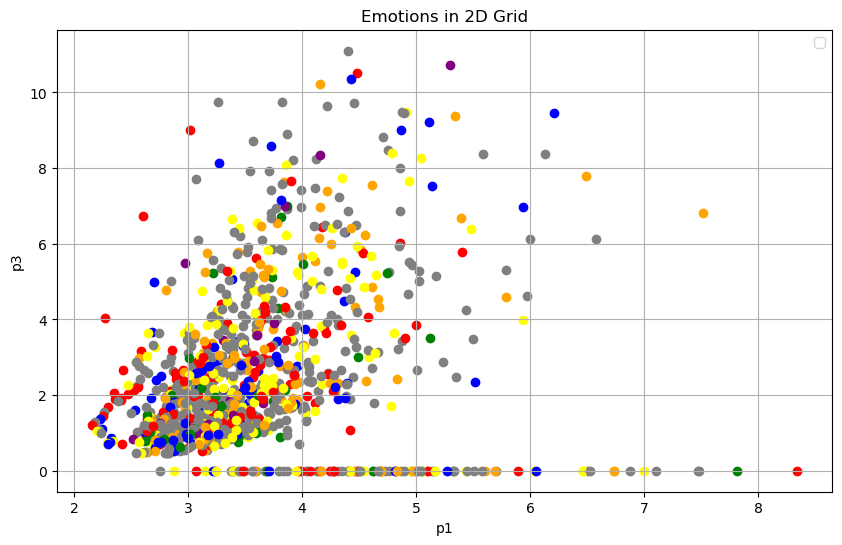

In [145]:
# Color map for emotions
emotion_color_map = {
    'anger': "red",
    'disgust': "purple",
    'fear': "green",
    'joy': "yellow",
    'neutral': "gray",
    'sadness': "blue",
    'surprise': "orange"
}

# Plotting
plt.figure(figsize=(10, 6))
for _, row in emotions_df.iterrows():
    print(row['p1'], row['p3'])
    plt.scatter(row['p1'], row['p3'], color=emotion_color_map[row['Emotion']])

plt.title("Emotions in 2D Grid")
plt.xlabel("p1")
plt.ylabel("p3")
plt.legend()
plt.grid(True)
plt.show()


In [62]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import plotly
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)
import seaborn as sns

In [63]:
cmp = 'algae'
def correlation_heatmap(y_cols, x_cols, full_data):
    '''
    Uses scipy.stats.spearmanr function
    Params:
    y_cols, x_cols: sets of column titles (strings)
    full_data: pandas dataframe that includes all columns listed in y_cols, x_cols
    Returns:
    corr: Spearman correlation coefficient matrix (y_cols = rows, x_cols = cols of matrix)
    fig_corr: annotated plotly heatmap of coefficients
    p: Spearman p-value matrix
    fig_p: annotated plotly heatmap of p-values
    '''
    cols = y_cols+x_cols
    all_correlations = scipy.stats.spearmanr(full_data[cols], nan_policy='omit')
    corr = all_correlations.statistic[:len(y_cols), -len(x_cols):]
    corr = pd.DataFrame(corr)
    corr.columns = x_cols
    corr.index = y_cols

    p = all_correlations.pvalue[:len(y_cols), -len(x_cols):]
    p = pd.DataFrame(p)
    p.columns = x_cols
    p.index = y_cols
    
    fig_corr = px.imshow(corr, text_auto=True, aspect='auto', color_continuous_scale='agsunset')
    fig_r2 = px.imshow(corr**2, text_auto=True, aspect='auto', color_continuous_scale='agsunset')
    fig_p = px.imshow(p, text_auto=True, aspect='auto', color_continuous_scale='gray_r')

    return corr, fig_corr, p, fig_p, fig_r2

In [64]:
def correlation(df_final):
    corr, fig_corr, p, fig_p, fig_r2 = correlation_heatmap(col_1, col_2, df_final)
    fig_corr.show()
    fig_p.show()
    fig_r2.show()
    return corr, fig_corr, p, fig_p, fig_r2

In [65]:
final_df = pd.concat((pd.DataFrame(dominance_p1).add_suffix("_P1",axis=0),pd.DataFrame(dominance_p2).add_suffix("_P2",axis=0),pd.DataFrame(dominance_p3).add_suffix("_P3",axis=0))).T
final_df

,SPK1_P1,SPK0_P1,SPK6_P1,SPK2_P1,SPK4_P1,SPK5_P1,SPK3_P1,SPK7_P1,SPK1_P3,SPK0_P3,SPK6_P3,SPK2_P3,SPK4_P3,SPK5_P3,SPK3_P3,SPK7_P3
S0,3.393806,3.923599,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.910570,NaN,NaN,NaN,NaN,NaN,NaN
S1,3.783404,3.521277,3.549329,3.472958,3.48608,3.474682,3.362399,NaN,2.339270,2.100690,0.747151,1.614507,1.665868,1.632769,1.163848,NaN
S2,5.138489,4.635524,NaN,NaN,NaN,NaN,NaN,NaN,3.916007,6.693259,NaN,NaN,NaN,NaN,NaN,NaN
S3,4.954532,4.313002,NaN,5.935415,NaN,NaN,NaN,NaN,0.000000,2.308389,NaN,3.976692,NaN,NaN,NaN,NaN
S4,3.852914,4.619921,NaN,3.620209,NaN,NaN,NaN,NaN,1.885585,4.576786,NaN,1.316767,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S109,3.924223,3.353735,NaN,3.580202,NaN,NaN,NaN,NaN,1.109343,2.235338,NaN,2.888636,NaN,NaN,NaN,NaN
S110,4.199405,3.803108,NaN,NaN,NaN,NaN,NaN,NaN,1.639098,0.978585,NaN,NaN,NaN,NaN,NaN,NaN
S111,4.616888,3.918103,NaN,NaN,NaN,NaN,NaN,NaN,2.711411,0.948173,NaN,NaN,NaN,NaN,NaN,NaN
S112,3.774139,4.175464,NaN,NaN,NaN,NaN,NaN,NaN,7.128459,5.834882,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
# p1 - p2
col_1 = ["MOD_P1","SPK1_P1","SPK2_P1"] 
col_2 = ["MOD_P2","SPK1_P2","SPK2_P2"]
corr, fig_corr, p, fig_p, fig_r2 = correlation(final_df)

KeyError: "['MOD_P1', 'MOD_P2', 'SPK1_P2', 'SPK2_P2'] not in index"

In [34]:
# p1 - p3
col_1 = ["MOD_P1","SPK1_P1","SPK2_P1"] 
col_2 = ["MOD_P3","SPK1_P3","SPK2_P3"]
corr, fig_corr, p, fig_p, fig_r2 = correlation(final_df)

In [35]:
# p2 - p3
col_1 = ["MOD_P1","SPK1_P1","SPK2_P1"] 
col_2 = ["MOD_P3","SPK1_P3","SPK2_P3"]
corr, fig_corr, p, fig_p, fig_r2 = correlation(final_df)

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import plotly
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)
import seaborn as sns

In [ ]:
y_s = final_results_ppxl_multisimo[["speaker_1_dom_score","speaker_2_dom_score"]]
X = final_results_ppxl_multisimo[["SPK1","SPK2"]]
col_1 = list(X.keys())
col_2 = list(y_s.keys())
corr, fig_corr, p, fig_p, fig_r2 = correlation(final_results_ppxl_multisimo[["speaker_1_dom_score","speaker_2_dom_score","SPK1","SPK2"]])

In [ ]:
dialog_filtered_tokens, info = perplexity_to_info_filtering_out_common_words(d,ppl_d,answers)
perpl = []
answers = []
for el in info:
    answers.append(el['label'])
    perpl += list(el['perpl'])
compute_graph_perplexity(dialog_filtered_tokens,perpl,answers=answers)

In [ ]:
###TO BE FIXED: there are some spaces that mess up the tokenization and detokenization

for el, dataset in zip(info, multisimo_df['file_content']):
    print(f"plotting {el}")
    dataset = re.sub(r'\[', r'\n[', content).split("\n")[1:]
    perplexity = []
    for sentence in info[el]:
        perplexity += list(sentence["perpl"]) 
    compute_graph_perplexity(dataset,perplexity)

In [ ]:
for i, (info_u, dataset) in enumerate(zip(info.keys(), considered_datasets_filtered)):
    for u, d in zip(info[info_u][1:], dataset.split("\n")[1:]):
        """filtering out assertive sentences like "'[Teacher]: "Very good. Continue."',
             '[Teacher]: "Please, go ahead."',
             '[Teacher]: "That\'s correct."',
             '[Teacher]: "Very good. Continue."',"""
        per_label_ppl[u['label']] += list(u['perpl'])
        per_label_dataset[u['label']].append(d)

### Tobedone when we have labels for MULTISIMO

In [ ]:
considered_datasets =multisimo_df["file_content"]

per_label_dataset={"Information seeking":[], "Information giving":[],"same":[]}
per_label_ppl={"Information seeking":[], "Information giving":[],"same":[]}

for dataset in considered_datasets:
    dataset = dataset.split("\n")
    labels = ["same" for _ in range(len(dataset))]
    encodings = tokenizer(dataset, return_tensors="pt")
    tokens_ids_per_sentence = np.cumsum([tokenizer(p, return_tensors="pt").input_ids.size(1) for p in dialog])
    prev_idx_pp = 0
    for idx, (d, l) in enumerate(zip(dataset,labels)):
        idx_pp = tokens_ids_per_sentence[idx]
        offset_ppl = len(tokenizer(d, return_tensors="pt"))
        per_label_dataset[l].append(d)
        per_label_ppl[l] += perplexity_scores[idx][prev_idx_pp:idx_pp]
        prev_idx_pp=idx_pp

### Other Dominance Indicators

In [ ]:
def count_user_utterances(content, pattern='<(SPK[1-9]|MOD)>'):
    content = " ".join(content)
    count_utterance_p_user = {}
    count_turns_p_user = {}
    matches = re.findall(pattern, "".join(content))
    content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
    for el in np.unique(np.array(matches)):
        all_utt_p_user = [c for c in content if el in c]
        all_utt_p_user_n = sum([len(u.split(".")) for u in all_utt_p_user])
        count_utterance_p_user[el]=len(all_utt_p_user)
        count_turns_p_user[el] = np.sum(np.asarray(matches) == el)
    return count_utterance_p_user, count_turns_p_user

In [ ]:
multisimo_df = pd.read_csv("/u/sebono/conversational_dominance/data/processed/multisimo/conversations.csv")

count_utterance_p_user_l = {}
count_turns_p_user_l = {}
for content, name in zip(multisimo_df["file_content"], multisimo_df["file_name"]):
    count_utterance_p_user_l[name] = {}
    count_turns_p_user_l[name] = {}
    print(name)
    dominance[name] = {}
    pattern = '<(SPK[1-9]|MOD)>'
    matches = re.findall(pattern, "".join(content))
    content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
    count_utterance_p_user, count_turns_p_user = count_user_utterances(content, pattern=pattern)
    for cu, ct in zip(count_utterance_p_user, count_turns_p_user):
        count_utterance_p_user_l[name][cu] = count_utterance_p_user[cu]
        count_turns_p_user_l[name][ct] = count_turns_p_user[ct]
        print(f"{cu}:", count_utterance_p_user[cu],count_turns_p_user[ct])

In [ ]:
count_utterance_p_user_l

In [ ]:
multisimo_df = pd.read_csv("../data/processed/multisimo/transcript_dominance.csv")

In [ ]:
df_ppxl = pd.DataFrame(count_utterance_p_user_l).T
df_ppxl.index.name = "file_name"
final_results_ppxl_multisimo = pd.merge(multisimo_df,df_ppxl, on="file_name")

In [ ]:
final_results_ppxl_multisimo

In [ ]:
results = pd.DataFrame({"one":final_results_ppxl_multisimo["speaker_1_dom_score"]>final_results_ppxl_multisimo["speaker_2_dom_score"],"two": final_results_ppxl_multisimo["SPK1"]>final_results_ppxl_multisimo["SPK2"]})
sum(results["one"]==results["two"])/len(results["one"])

### Teacher Dominated

In [ ]:
import pandas as pd
file_path = "/u/sebono/conversational_dominance/data/results/information_labels__teacher_dominated__withneutral.csv"
datasets = pd.read_csv(file_path).reset_index()

In [ ]:
ppl = {}
for index, dataset in zip(datasets["index"],datasets["transcript"]):
    dataset = dataset.split("\n")
    pattern = r'\[([^\]]+)\]'
    matches = re.findall(pattern, "".join(dataset))    
    perpl = perplexity_of_fixedlength_models(dataset)
    ppl[index] = perpl

In [ ]:
#import pickle
#file_path = "/u/sebono/conversational_dominance/data/results/information_labels__teacher_dominated__withneutral_perplexity_scores.pikle"
#with open(file_path, 'wb') as file:
#    pickle.dump(ppl, file)

In [ ]:
import pickle
file_path = "/u/sebono/conversational_dominance/data/results/information_labels__teacher_dominated__withneutral_perplexity_scores.pikle"
with open(file_path, 'rb') as file:
    perplexity_scores = pickle.load(file)

In [ ]:
considered_indices = datasets[datasets["n_responses_match"] == True]["index"]
considered_datasets =  datasets[datasets["n_responses_match"] == True]

considered_datasets["transcript"].iloc[-1]

In [ ]:
import re

considered_indices = datasets[datasets["n_responses_match"] == True]["index"]
considered_datasets =  datasets[datasets["n_responses_match"] == True]

per_label_dataset={"Information seeking":[],"Neutral": [],  "Information giving":[]}
per_label_ppl={"Information seeking":[], "Neutral": [], "Information giving":[]}

info = {}
considered_datasets_filtered = []
for dataset, response, ppl_idx in zip(considered_datasets["transcript"],considered_datasets["response"], considered_indices):
    #encodings = [tokenizer(d, return_tensors="pt").input_ids[0] for d in dataset.split("\n")]
    dataset = dataset.split("\n")
    encodings = tokenizer(" ".join(dataset), return_tensors="pt", return_offsets_mapping=True).input_ids.ravel()
    dataset_filtered, info[ppl_idx] = perplexity_to_info_filtering_out_common_words(dataset,encodings,perplexity_scores[ppl_idx],response.split("\n"))
    considered_datasets_filtered.append(dataset_filtered)

In [ ]:
per_label_ppl

In [ ]:
per_label_dataset={"Information seeking":[],"Neutral": [],  "Information giving":[]}
per_label_ppl={"Information seeking":[], "Neutral": [], "Information giving":[]}
for i, (info_u, dataset) in enumerate(zip(info.keys(), considered_datasets_filtered)):
    for u, d in zip(info[info_u], dataset):
        """filtering out assertive sentences like "'[Teacher]: "Very good. Continue."',
             '[Teacher]: "Please, go ahead."',
             '[Teacher]: "That\'s correct."',
             '[Teacher]: "Very good. Continue."',"""
        assert len(u['perpl']) == len(d)
        per_label_ppl[u['label']] += list(u['perpl'])
        per_label_dataset[u['label']].append(d)

In [ ]:
#information giving
pattern = r'\[([^\]]+)\]'
tokens = per_label_dataset["Neutral"]
perplexity = per_label_ppl["Neutral"]
compute_graph_perplexity(tokens, perplexity,pattern=pattern)

In [ ]:
#information giving
tokens = per_label_dataset["Information giving"]
perplexity = per_label_ppl["Information giving"]
compute_graph_perplexity(tokens, perplexity)

In [ ]:
len(per_label_ppl["Information giving"]), len(per_label_dataset["Information giving"])

In [ ]:
perplexity = per_label_ppl["Neutral"]
np.nanmean(perplexity), np.nanstd(perplexity)

In [ ]:
perplexity = per_label_ppl["Information giving"]
np.nanmean(perplexity), np.nanstd(perplexity)

In [ ]:
perplexity = per_label_ppl["Information seeking"]
np.nanmean(perplexity), np.nanstd(perplexity)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming per_label_ppl is a dictionary containing data for "Information seeking" and "Information giving"

# Create a figure and axis
fig, ax = plt.subplots()

# Plot KDE using seaborn
sns.kdeplot(per_label_ppl["Information seeking"], color='blue', label='Information seeking', ax=ax, cut=0, clip=(0, 4))
sns.kdeplot(per_label_ppl["Information giving"], color='green', label='Information giving', ax=ax, cut=0, clip=(0, 4))
sns.kdeplot(per_label_ppl["Neutral"], color='yellow', label='Neutral', ax=ax, cut=0, clip=(0, 4))

# Adding labels and legend
ax.set_xlabel('Values')
ax.set_ylabel('Density')
ax.legend()

# Display the plot
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming per_label_ppl is a dictionary containing data for "Information seeking" and "Information giving"

# Create a figure and axis
fig, ax = plt.subplots()

# Plot histograms using seaborn with density=True
sns.histplot(per_label_ppl["Information seeking"], kde=True, color='blue', label='Information seeking', ax=ax, stat='density')
sns.histplot(per_label_ppl["Information giving"], kde=True, color='green', label='Information giving', ax=ax, stat='density')
sns.histplot(per_label_ppl["Neutral"], kde=True, color='yellow', label='Neutral', ax=ax, stat='density')

# Adding labels and legend
ax.set_xlabel('Values')
ax.set_ylabel('Density')
ax.legend()

# Display the plot
plt.show()


In [ ]:
#lower perplexity
dataset = per_label_dataset["Information seeking"]
perplexity = per_label_ppl["Information seeking"]
pattern = r'\[([^\]]+)\]'
compute_graph_perplexity(dataset,perplexity)

### Emotion Extraction